## imports

In [ ]:
import os
import zipfile
import shutil
from pathlib import Path
import random
import glob
import pandas as pd
import numpy as np

import tensorflow as tf
import albumentations as A
import cv2
import numpy as np
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report


from tensorflow import keras, TensorSpec
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout, Flatten, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import *
from tensorflow.keras.initializers import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.data import Dataset, experimental


import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

## definitions to set by user

In [78]:
# set "machine" according to where you want to run the script

machine = 'local' # 'colab' or 'local'

# modelname: 
model_name = 'inceptionv3_02'


IMG_HEIGHT, IMG_WIDTH = 299, 299
NUM_CLASSES = 4
BATCH_SIZE = 16

classes = ['Normal', 'COVID', 'Lung_Opacity', 'Viral Pneumonia']
class_to_index = {cls: idx for idx, cls in enumerate(classes)}
index_to_class =  {v: k for k, v in class_to_index.items()} # Invert the dictionary

# random number in order to reproduce the split etc. 
rand_num = 42

## load directories on colab

In [ ]:
if machine == 'colab':
    #from google.colab import files
    #files.upload()

    # load google drive when working on colab
    from google.colab import drive
    #drive.mount('/content/drive')
    drive.mount("/content/drive", force_remount=True)

## definitions

In [ ]:
#####################################
# paths:
#####################################

if machine == 'local':
    # paths to load data:
    base_path = r"..\\data\\"
    base_path_zip = os.path.join(base_path, "raw")                       # path where zip-file is
    base_path_raw = base_path_zip                                        # path where raw data is unziped to  (on local machine same as path where zip is)
    base_path_processed = os.path.join(base_path, "processed", "DL")     # path where processed data is saved

    # paths to save models:
    model_path = r"..\\Models\\local\\DL"

elif machine == 'colab':
    # paths to load data:
    base_path_drive     = '/content/drive/MyDrive/data'         # base path on DRIVE
    base_path_colab     =  '/content/data'                      # base path on COLAB
    base_path_zip       = os.path.join(base_path_drive, 'raw')  # path where zip-file is (on drive)
    base_path_raw       = os.path.join(base_path_colab, 'raw')  # path where raw data is unziped to (on colab machine not on drive)
    base_path_processed = os.path.join(base_path_colab, 'raw')  # path where processed data is saved (on colab machine not on drive)


    # paths to save models:
    model_path = '/content/drive/MyDrive/models/DL'

In [ ]:
archive_zip = 'covid19-radiography-database.zip'
unzipped_folder = 'COVID-19_Radiography_Dataset'

if machine == 'local':

    # only unzip if target folder not already exists:
    if not os.path.exists(os.path.join(base_path_raw,unzipped_folder)):
        with zipfile.ZipFile(os.path.join(base_path_zip, archive_zip), 'r') as zip_ref:
            for file_name in zip_ref.namelist():
                zip_ref.extract(file_name, base_path_raw)  # Extract files into target folder
            print("zip-archive {} unziped to folder: {}." .format(archive_zip, os.path.join(base_path_raw,unzipped_folder)))
    else:
        print('Nothing to unzip, folder already exist.')

elif machine == 'colab':
    # create directory 
    os.makedirs(base_path_raw, exist_ok=True)
    os.makedirs(base_path_processed, exist_ok=True)

    # only unzip if target folder not already exists:
    if not os.path.exists(os.path.join(base_path_raw,unzipped_folder)):
        with zipfile.ZipFile(os.path.join(base_path_zip, archive_zip), 'r') as zip_ref:
            for file_name in zip_ref.namelist():
                zip_ref.extract(file_name, base_path_raw)  # Extract files into target folder
            print("zip-archive {} unziped to folder: {}." .format(archive_zip, os.path.join(base_path_raw,unzipped_folder)))
    else:
        print('Nothing to unzip, folder already exist.')      


Nothing to unzip, folder already exist.


## Train - test split

In [ ]:
random.seed(rand_num)

# Set paths for source (downloaded data) and destination (processed train/test)
source_dir = os.path.join(base_path_raw, unzipped_folder) 
dest_dir = base_path_processed  

train_dir = os.path.join(dest_dir, "train_data_with_masks")
test_dir = os.path.join(dest_dir, "test_data_with_masks")

split_ratio = 0.85

for cls in classes:
    print(f"Processing class: {cls}")

    # Paths to images and masks in raw data
    images_path = os.path.join(source_dir, cls, "images")
    masks_path = os.path.join(source_dir, cls, "masks")

    # List image files only
    all_images = [img for img in os.listdir(images_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
    random.shuffle(all_images)

    split_index = int(len(all_images) * split_ratio)
    train_imgs = all_images[:split_index]
    test_imgs = all_images[split_index:]

    # Create destination directories
    train_img_dir = os.path.join(train_dir, cls, "images")
    train_mask_dir = os.path.join(train_dir, cls, "masks")
    test_img_dir = os.path.join(test_dir, cls, "images")
    test_mask_dir = os.path.join(test_dir, cls, "masks")

    os.makedirs(train_img_dir, exist_ok=True)
    os.makedirs(train_img_dir, exist_ok=True)
    os.makedirs(train_mask_dir, exist_ok=True)
    os.makedirs(test_img_dir, exist_ok=True)
    os.makedirs(test_mask_dir, exist_ok=True)

    # Copy images and corresponding masks
    for img in train_imgs:
        shutil.copy(os.path.join(images_path, img), os.path.join(train_img_dir, img))
        mask_file = os.path.join(masks_path, img)
        if os.path.exists(mask_file):
            shutil.copy(os.path.join(mask_file), os.path.join(train_mask_dir, img))

    for img in test_imgs:
        shutil.copy(os.path.join(images_path, img), os.path.join(test_img_dir, img))
        mask_file = os.path.join(masks_path, img)
        if os.path.exists(mask_file):
            shutil.copy(mask_file, os.path.join(test_mask_dir, img))

    print(f"  Copied {len(train_imgs)} images (and masks if available) to {train_img_dir}")
    print(f"  Copied {len(test_imgs)} images (and masks if available) to {test_img_dir}")


Processing class: Normal
  Copied 8663 images (and masks if available) to ..\\data\\processed\DL\train_data_with_masks\Normal\images
  Copied 1529 images (and masks if available) to ..\\data\\processed\DL\test_data_with_masks\Normal\images
Processing class: COVID
  Copied 3073 images (and masks if available) to ..\\data\\processed\DL\train_data_with_masks\COVID\images
  Copied 543 images (and masks if available) to ..\\data\\processed\DL\test_data_with_masks\COVID\images
Processing class: Lung_Opacity
  Copied 5110 images (and masks if available) to ..\\data\\processed\DL\train_data_with_masks\Lung_Opacity\images
  Copied 902 images (and masks if available) to ..\\data\\processed\DL\test_data_with_masks\Lung_Opacity\images
Processing class: Viral Pneumonia
  Copied 1143 images (and masks if available) to ..\\data\\processed\DL\train_data_with_masks\Viral Pneumonia\images
  Copied 202 images (and masks if available) to ..\\data\\processed\DL\test_data_with_masks\Viral Pneumonia\images


## resplit the train set into train (80%) and validation (20%) set

In [ ]:
data_dir = train_dir

all_img_paths = []
all_class_indices = []

for class_name in classes:
    class_dir = os.path.join(data_dir, class_name, "images")
    img_files = glob.glob(f"{class_dir}/*.png")
    for img_file in img_files:
        all_img_paths.append(str(img_file))
        all_class_indices.append(class_to_index[class_name])

# Train/val split
train_imgs, val_imgs, train_labels, val_labels = train_test_split(
    all_img_paths, all_class_indices, test_size=0.2, stratify=all_class_indices, random_state=rand_num
)

## data augmentation for the train set

In [ ]:
# Define augmentation pipeline

# define probabilities of applying the different augmentation methods
prob_rotate = 0.5    # probaility of using rotation
prob_shift = 0.5     # probaility of using shifting
prob_pipeline = 1.0  # The entire pipeline has a 100% chance to be applied. We want every image to be changed


# Define the augmentation pipeline
augmentation_pipeline = A.Compose([
    A.OneOf([
        A.Rotate(limit=15, p=prob_rotate),                                                 # Rotate with a limit of ±15 degrees
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0, rotate_limit=0, p=prob_shift)  # Translation (shifting)
    ], p=prob_pipeline)

], p=1.0,                    # probability of the entire pipeline to be applied
seed = rand_num,                  # added seed for reproducibility  
save_applied_params=True)    # save applied transformation parameters

c:\Users\Yvonne\Documents\DataScientist_2025_local\project_code\.venv-xray\Lib\site-packages\albumentations\core\validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [ ]:
# assume that the normal class (label = 0) is the majority class and only the other classes have to be augmented:
class_aug = [1,2,3]

# determine number of images for normal class (label = 0) in train data set:
counts = pd.Series(train_labels).value_counts()
max_num = counts[0]

iteration_per_class = {}

for class_label in [0,1,2,3]:
    class_num = counts[class_label]

    div_res = round(max_num/class_num,0)    # calculate how many augmentation iteration we need
    iteration = div_res - 1                 # it needs one iteration less, because we add the unaugmented data
    
    iteration_per_class.update({class_label: iteration})

In [ ]:
train_imgs_aug = []
train_labels_aug = []

# loop through items of list with training images and corresponding labels
for label, img_path in zip(train_labels, train_imgs):
    # only do augmentation if class is not 'Normal'
    if label in class_aug:

        # define output path for augmented image
        augmented_dir = os.path.split(img_path)[0]
        

        # how many iterations of augmentation do we need?
        num_iter = iteration_per_class[label]

        
        iter = 1
        # for each file in the data frame to as many augmentation, as needed for this class
        
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            while iter <= num_iter: 
                      
                augmented = augmentation_pipeline(image=img)
                augmented_img = augmented['image']
                
                # save used transformation to dict
                #used_transformation.update({img_name:augmented['applied_transforms']})
                        
                # define name for augmented image
                split_name, split_ending = os.path.split(img_path)[1].split('.') 
                img_name_aug = split_name + "_ag" + str(iter) + "." + split_ending

                # save augmented image
                save_path = os.path.join(augmented_dir, img_name_aug)
                cv2.imwrite(save_path, augmented_img)
                
                # append path to new augmented image to list train_imgs_aug:
                train_imgs_aug.append(save_path)
                train_labels_aug.append(label)

                iter +=1
    
# append augmented img and labels to lists for train data:
train_imgs.extend(train_imgs_aug)
train_labels.extend(train_labels_aug)

In [ ]:
counts = pd.Series(train_labels).value_counts()
print('number of images per class after augmentation:')
print(counts)

## create tensors: train, validation

In [ ]:
# ----------- Data Generator -----------

def load_classification_image(img_path, label):
    img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))

    #img = img.astype(np.float32) / 255.0 # does not need to be done, because preprocess_input function of InceptionV3 model does it later
    img = np.stack([img]*3, axis=-1)  # convert grayscale to RGB
    return img, label

def classification_generator(img_paths, labels):
    for img_path, label in zip(img_paths, labels):
        img, lbl = load_classification_image(img_path, label)
        yield img, lbl

def create_classification_dataset(img_paths, labels, batch_size):
    dataset = tf.data.Dataset.from_generator(
        lambda: classification_generator(img_paths, labels),
        output_signature=(
            tf.TensorSpec(shape=(IMG_HEIGHT, IMG_WIDTH, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(), dtype=tf.int32)
        )
    )
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

train_ds = create_classification_dataset(train_imgs, train_labels, batch_size=BATCH_SIZE)
val_ds = create_classification_dataset(val_imgs, val_labels, batch_size=BATCH_SIZE)

print(f"Train batches: {len(list(train_dataset))}")
print(f"Validation batches: {len(list(val_dataset))}")

Train batches: 1863
Validation batches: 225


## create tensors: test

In [ ]:
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np
from pathlib import Path

TEST_DATA_DIR = test_dir

X_test_raw = []
y_test_raw = []

for cls_index, cls_name in enumerate(classes):
    img_dir = os.path.join(TEST_DATA_DIR, cls_name, "images")
    img_files = glob.glob(f"{img_dir}/*.png")

    for img_file in img_files:
        img = load_img(img_file, target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode='grayscale')
        img_array = img_to_array(img).astype(np.float32) / 255.0
        img_array = np.repeat(img_array, repeats=3, axis=-1)  # Convert grayscale to RGB

        X_test_raw.append(img_array)
        y_test_raw.append(cls_index)  # Image-level class label

# Convert to NumPy arrays
X_test = np.array(X_test_raw, dtype=np.float32)
y_test = np.array(y_test_raw, dtype=np.int32)

print("X_test shape:", X_test.shape)  # (N, 224, 224, 3)
print("y_test shape:", y_test.shape)  # (N,)


test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


X_test shape: (3176, 299, 299, 3)
y_test shape: (3176,)


In [ ]:
# train_ds = train_dataset
# test_ds = test_dataset
# val_ds = val_dataset

## display some images

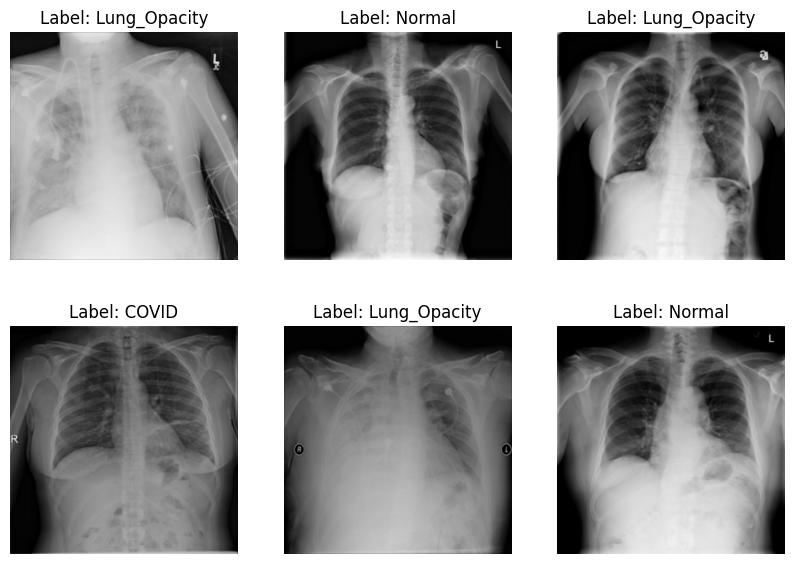

In [83]:
# Define the number of images to display
number_of_images = 6

# Create a figure for displaying
plt.figure(figsize=(10,7))

# Get a batch of images from train_ds
for batch, labels in train_ds.take(1):
    # Display the images from the batch
    for i in range(number_of_images):
        ax = plt.subplot(2, 3, i + 1) 
        plt.imshow(batch[i].numpy())  # Convert the image to integer for display
        plt.axis("off") 
        plt.title(f"Label: {index_to_class[labels[i].numpy()]}")  

# Show the images
plt.show()

# Modelling

## define the model

In [84]:
# InceptionV3 model
base_model = InceptionV3(weights='imagenet', include_top=False)

# Freeze the layers of InceptionV3
base_model.trainable = False

# Model creation using the Functional API
inputs = Input(shape=(299, 299, 3))

x = preprocess_input(inputs)   # kerase InceptionV3 preprocess_input function

# Apply augmentations
# x = RandomRotation(0.1)(inputs)                          
# x = RandomTranslation(height_factor=0.1, width_factor=0.1)(x) 
# x = RandomZoom(0.1)(x)  
# x = RandomFlip("horizontal")(x)

# Build the model
x = base_model(x)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(rate=0.2)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(rate=0.2)(x)
x = Dense(256, activation="relu")(x)  # Extra learning capacity
x = Dense(128, activation="relu")(x)  # Fine-tuning details
outputs = Dense(4, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)


## Compile the model



In [ ]:
# model.compile(
#     optimizer=Adam(learning_rate=0.0001),
#     loss='sparse_categorical_crossentropy',  # or 'sparse_categorical_crossentropy' if labels are not one-hot
#     metrics=['accuracy']
# )

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 8, 8, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,590,500 (93.81 MB)

 Trainable params: 2,787,716 (10.63 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [89]:
## define steps per epoche:
steps_per_epoch = len(train_imgs) // BATCH_SIZE  # Total samples / batch size
validation_steps = len(val_imgs) // BATCH_SIZE


# --- Callbacks ---
early_stop = EarlyStopping(patience=5, restore_best_weights=True)

early_stopping = EarlyStopping(
    monitor = 'val_loss',
    min_delta = 0.01,   # If the loss function doesn't change by 1% after 5 epochs, either up or down, we stop
    patience = 5,       # Wait for 5 epochs before applying
    verbose = 1,        # to display the epoch at which training stops
    mode = 'min',
    restore_best_weights=True
)

save = ModelCheckpoint(os.path.join(model_path, model_name + ".keras"), 
                                save_best_only=True, 
                                monitor='val_accuracy',
                                mode='min')



# --- Train model ---
history = model.fit(train_ds,
    validation_data=val_ds,
    epochs=25,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[early_stop, save]
)

# train the model 

# history_model = model.fit(train_ds, 
#                           epochs=5,
#                           validation_data=val_ds)


Epoch 1/25
 128/1862 ━━━━━━━━━━━━━━━━━━━━ 22:43 787ms/step - accuracy: 0.4591 - loss: 1.2353

KeyboardInterrupt: 

## Evaluation

In [ ]:
plt.figure(figsize=(12,4))

plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower left')

plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy by epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()



In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [ ]:
def get_predictions_and_labels(dataset):
    true_labels = []
    pred_labels = []

    for images, labels in dataset:
        
        preds = model.predict(images, verbose=0)  # Get the model's predictions
        #pred_labels.extend(np.argmax(preds, axis=-1))  # Get the predicted labels (argmax)
        pred_labels.extend(preds)  # Get the predicted labels (argmax)

        true_labels.extend(labels.numpy())  # Get the true labels

    return np.array(true_labels), np.array(pred_labels)

y_true, y_pred = get_predictions_and_labels(test_ds)  # Get true labels and predictions from the test dataset

# Display the classification report
print(classification_report(y_true, y_pred))  # Print the classification report (precision, recall, F1-score)

# Display the confusion matrix
plt.figure(figsize=(10, 10))  # Create a large figure for the confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred, normalize='true')  # Compute the normalized confusion matrix
sns.heatmap(cnf_matrix, cmap='Blues', annot=True, cbar=False, fmt=".2f")  # Plot the confusion matrix as a heatmap